In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Core

> The `text.core` module contains the core bits required to use fast.ai's low-level and/or mid-level APIs to define `Datasets`, build `DataLoaders`, and train text/NLP models with fast.ai

In [ ]:
# |default_exp text.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from datasets import concatenate_datasets, load_dataset
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.block import TransformBlock
from fastai.data.transforms import DataLoader, DataLoaders, Datasets, ColSplitter, ItemTransform, TfmdDL
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.test_utils import show_install
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoConfig, AutoTokenizer, PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
from transformers import AutoModelForSequenceClassification
from transformers import logging as hf_logging
from transformers.data.data_collator import DataCollatorWithPadding

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb

from datasets import Value
from fastai.data.block import MultiCategoryBlock, CategoryBlock, ColReader, ColSplitter, DataBlock, ItemGetter, RandomSplitter, FuncSplitter
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import print_versions, PreCalculatedCrossEntropyLoss, PreCalculatedBCELoss, PreCalculatedMSELoss

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

In [ ]:
def get_new_hf_objects(labels):
    model_cls = AutoModelForSequenceClassification
    hf_logging.set_verbosity_error()

    pretrained_model_name = "microsoft/deberta-v3-small"
    n_labels = len(labels)

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
    )

    hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

    print("=== config ===")
    print(f"# of labels:\t{hf_config.num_labels}")
    print("")
    print("=== tokenizer ===")
    print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
    print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
    print(f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}")

    return hf_arch, hf_config, hf_tokenizer, hf_model

### Multiclass

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = imdb_dsd[0].add_column("is_valid", [False] * len(imdb_dsd[0])).shuffle().select(range(1000))
valid_ds = imdb_dsd[1].add_column("is_valid", [True] * len(imdb_dsd[1])).shuffle().select(range(200))
imdb_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(len(imdb_df[imdb_df["is_valid"] == False]), len(imdb_df[imdb_df["is_valid"] == True]))
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"At two and a quarter hours this is a sometimes slow moving thoughtful film interrupted by vast sword battles. The battle between darkness and light is signified by the constant motif of the blazing sun and is superbly demonstrated by a three way fight between 'demons', bandits and soldiers in a forest during an eclipse.<br /><br />Be prepared: following a stunning sword fight under lightning filled skies the end of this picture will have you scratching your head in puzzlement.",1,False
1,"If you know the story of Grey Owl, you'll love the movie! Annie Galipeau is a great actress, and Pierce is better than never in Grey Owl. But in this movie there's no real scene of action. I think this movie should be nominated at the Oscars! Welll go see this movie, it's A CLASSIC!",1,False
2,"The closing song by Johnny Rivers was the only great thing about this movie. Unfortunately that is all the positive I can say about this western movie. I have to write 8 more lines for my comments to be posted, but there is more than 8 lines of awful in this western. I am not sure if the movie was a tribute to Hopa Along, or just a spoof. The hero and the villain in this movie were too plastic. Not realistic at all. A lot of the supporting actors in this movie looked authentic, but the shooting scenes were a joke. A previous commentator thought this movie was great, and in the comments too...",0,False
3,"I settled back to watch ""Read My Lips,"" a plate of Freedom Fries before me. The food was quickly forgotten as I became engrossed by director and co-writer Jacques Audiard's original and superb thriller.<br /><br />Carla (Emmanuelle Devos) is a secretary at a firm that develops major building projects. She actually has some significant responsibilities that don't often fall to secretaries and she's capable and ambitious. And thwarted by a male hierarchy that will exploit but not reward her.<br /><br />Work piling up faster than she can handle it, Carla is told to hire a secretary. Enter ex-...",1,False
4,"Debbie Reynolds toe-taps, tangos and, yes, tap-dances her way through this ordinary thriller which has a distinctly fabricated '30s atmosphere. Two ladies, brought together when their sons commit a murder, try starting their lives over by running a tap-dance school for tots in Hollywood. Trouble is, one of them is plagued by neuroses. Can you imagine this thing 10 years earlier with Robert Aldrich directing Bette Davis and Joan Crawford...? Nahh, Bette never would have allowed Joan so much screen-time to strut her stuff, and I can't imagine Bette Davis in the other role, tap-dancing her he...",0,False


In [ ]:
labels = imdb_dsd[0].features["label"].names
labels

['neg', 'pos']

### Multilabel

In [ ]:
civil_dsd = load_dataset("civil_comments", split=["train", "validation"])

# round the floats
civil_labels = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]


def round_targs(example):
    for lbl in civil_labels:
        example[lbl] = np.round(example[lbl])
    return example


# convert floats to ints
def fix_dtypes(ds):
    new_features = ds.features.copy()
    for lbl in civil_labels:
        new_features[lbl] = Value("int32")
    return ds.cast(new_features)


# build HF `Dataset` objects
civil_train_ds = civil_dsd[0].add_column("is_valid", [False] * len(civil_dsd[0])).shuffle().select(range(1000))
civil_train_ds = civil_train_ds.map(round_targs)
civil_train_ds = fix_dtypes(civil_train_ds)

civil_valid_ds = civil_dsd[1].add_column("is_valid", [True] * len(civil_dsd[1])).shuffle().select(range(200))
civil_valid_ds = civil_valid_ds.map(round_targs)
civil_valid_ds = fix_dtypes(civil_valid_ds)

civil_ds = concatenate_datasets([civil_train_ds, civil_valid_ds])

# build a `DataFrame` representation as well
civil_df = pd.DataFrame(civil_ds)

print(len(civil_train_ds), len(civil_valid_ds))
print(len(civil_df[civil_df["is_valid"] == False]), len(civil_df[civil_df["is_valid"] == True]))
civil_df.head()

Found cached dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200
1000 200


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,is_valid
0,"But you missed the 2nd order point as happens so often with reflexive/defensive type commenters: Even in a merely temporal sense (not to mention the supernatural effect which was an infinitely horrific offense) the violence against Jesus lowered the bar all around the people who witnessed it or even learned about it...they could go home and slap their wife and say..""well, this is nothing compared to the Nazarenian."" \n\nJesus let a coarser and more grotesque example be set, lowering the bar for all. He was complicit in it...He allowed it, even as a man. \n\nSo the ""non violent"" types ough...",0,0,0,0,0,0,0,False
1,I wonder if you'd be quite so cavalier in excluding half the human race in Scriptural and liturgical language if your name were Donna or Danette or Denise? Language matters.,0,0,0,0,0,0,0,False
2,We're all so overjoyed with this news.,0,0,0,0,0,0,0,False
3,"In an era of renewed health consciousness in an aging population, I could see this production experiment as being a small tip of a very large iceberg to come. My guess is that with care, the seaweed industry could very easily be wildly successful in Alaska.\nSo good luck with this venture!",0,0,0,0,0,0,0,False
4,"The laws are too weak and protect the criminals,, we must protect ourselves, and if mugged or burglarized... shoot to kill. It's time we fight back instead of giving them a timeout.",1,0,0,1,0,0,0,False


## Core: Data

A base collation function that works with a variety of input formats and pads inputs on-the-fly at batch time

### `TextCollatorWithPadding` -

In [ ]:
# |export
@dataclass
class TextCollatorWithPadding:
    def __init__(
        self,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str = None,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig = None,
        # A Hugging Face model
        hf_model: PreTrainedModel = None,
        # The number of inputs expected by your model
        n_inp: int = 1,
        # Defaults to use Hugging Face's DataCollatorWithPadding(tokenizer=hf_tokenizer)
        data_collator_cls: type = DataCollatorWithPadding,
        # kwyargs specific for the instantiation of the `data_collator`
        data_collator_kwargs: dict = {},
    ):
        store_attr()
        self.hf_tokenizer = data_collator_kwargs.pop("tokenizer", self.hf_tokenizer)
        self.data_collator = data_collator_cls(tokenizer=self.hf_tokenizer, **data_collator_kwargs)

    def __call__(self, features):
        features = L(features)
        inputs, labels, targs = [], [], []

        # features contain dictionaries
        if isinstance(features[0], dict):
            feature_keys = list(features[0].keys())
            inputs = [self._build_inputs_d(features, feature_keys)]

            input_labels = self._build_input_labels(features, feature_keys)
            if input_labels is not None:
                labels, targs = [input_labels], [input_labels.clone()]
        # features contains tuples, each of which can contain multiple inputs and/or targets
        elif isinstance(features[0], tuple):
            for f_idx in range(self.n_inp):
                feature_keys = list(features[0][f_idx].keys())
                inputs.append(self._build_inputs_d(features.itemgot(f_idx), feature_keys))

                input_labels = self._build_input_labels(features.itemgot(f_idx), feature_keys)
                labels.append(input_labels if input_labels is not None else [])

            targs = [self._proc_targets(list(features.itemgot(f_idx))) for f_idx in range(self.n_inp, len(features[0]))]

        return self._build_batch(inputs, labels, targs)

    # ----- utility methods -----

    # to build the inputs dictionary
    def _build_inputs_d(self, features, feature_keys):
        return {fwd_arg: list(features.attrgot(fwd_arg)) for fwd_arg in self.hf_tokenizer.model_input_names if fwd_arg in feature_keys}

    # to build the input "labels"
    def _build_input_labels(self, features, feature_keys):
        if "label" in feature_keys:
            labels = list(features.attrgot("label"))
            return self._proc_targets(labels)
        return None

    # used to give the labels/targets the right shape
    def _proc_targets(self, targs):
        if is_listy(targs[0]):
            targs = torch.stack([tensor(lbls) for lbls in targs])
        elif isinstance(targs[0], torch.Tensor) and len(targs[0].size()) > 0:
            targs = torch.stack(targs)
        else:
            targs = torch.tensor(targs)

        return targs

    # will properly assemble are batch given a list of inputs, labels, and targets
    def _build_batch(self, inputs, labels, targs):
        batch = []

        for input, input_labels in zip(inputs, labels):
            input_d = dict(self.data_collator(input))
            if len(input_labels) > 0:
                input_d["labels"] = input_labels
            batch.append(input_d)

        for targ in targs:
            batch.append(targ)

        return tuplify(batch)

## Core: Training

Base plitters for defining paramater groups, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules: Module | list[Module]):
    "Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
nbdev.show_doc(blurr_params, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L132){target="_blank" style="float:right; font-size:smaller"}

### blurr_params

>      blurr_params
>                    (modules:fastai.torch_core.Module|list[fastai.torch_core.Mo
>                    dule])

Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L139){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
# |export
def blurr_splitter_on_head(m: Module):
    """Creates two layers groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L151){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layers groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs,
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model, **self.base_model_wrapper_kwargs)

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Core: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader` iterators and train your model using the fast.ai `Learner`. 

**Note** that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["At two and a quarter hours this is a sometimes slow moving thoughtful film interrupted by vast sword battles. The battle between darkness and light is signified by the constant motif of the blazing sun and is superbly demonstrated by a three way fight between 'demons', bandits and soldiers in a forest during an eclipse.<br /><br />Be prepared: following a stunning sword fight under lightning filled skies the end of this picture will have you scratching your head in puzzlement.", "If you know the story of Grey Owl, you'll love the movie! Annie Galipeau is a great actress, and Pierce is better than never in Grey Owl. But in this movie there's no real scene of action. I think this movie should be nominated at the Oscars! Welll go see this movie, it's A CLASSIC!"], 'label': [1, 1], 'is_valid': [False, False]}

["At two and a quarter hours this is a sometimes slow moving thoughtful film interrupted by vast sword battles. The battle between dar

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTextClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTextClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] For real film people, this film is a must, since it works as a perfect little allegory for the movies themselves. Janos Rukh/Boris Karloff's science has to do with capturing and projecting light from cosmic phenomena. This light can do harm, or it can be harnessed to do good. On the one hand it blinds his mother, on the other it is used to cure blindness ("I can see!" shouts a young girl on whose eyes this light is projected). When Rukh/Karloff is himself poisoned by the uncanny power of this light, we see him actually emitting a ghostly glow on his hands and face like a badly developed negative, drawing attention to the fact that the man we are watching is a projection, an entity viewed on film (only visible, as in a movie theater, when the lights are out).<br /><br />There is a wonderful passage near the beginning where Karloff/Rukh explains his research as being

tensor([1, 1, 0, 1])


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=2.7542287170945203e-07, steep=1.0964781722577754e-06, valley=0.00019054606673307717, slide=0.0005754399462603033)

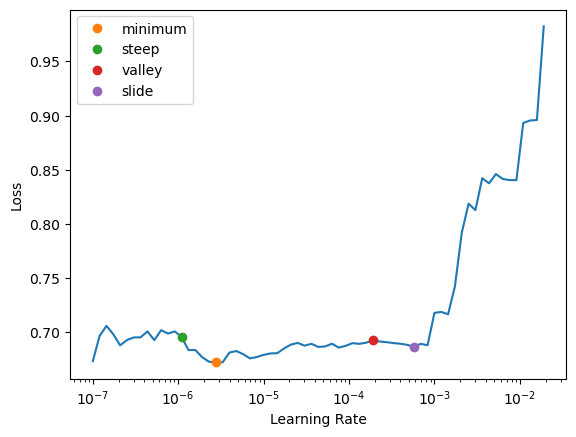

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.696993,0.677828,0.520000,00:22
1,0.191354,0.212283,0.900000,00:22
2,0.149719,0.218115,0.910000,00:22


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.14971861243247986
valid_loss 0.2181149274110794
accuracy 0.9100000262260437


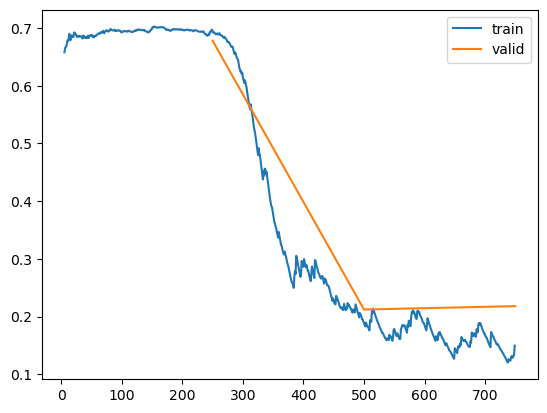

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `torch.utils.data.Dataset`s

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['But you missed the 2nd order point as happens so often with reflexive/defensive type commenters: Even in a merely temporal sense (not to mention the supernatural effect which was an infinitely horrific offense) the violence against Jesus lowered the bar all around the people who witnessed it or even learned about it...they could go home and slap their wife and say.."well, this is nothing compared to the Nazarenian." \n\nJesus let a coarser and more grotesque example be set, lowering the bar for all.  He was complicit in it...He allowed it, even as a man. \n\nSo the "non violent" types ought to ask themselves a more demanding question, why?', "I wonder if you'd be quite so cavalier in excluding half the human race in Scriptural and liturgical language if your name were Donna or Danette or Denise?  Language matters."], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + civil_labels)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextMultilabelClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer, labels):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        item["label"] = [item[lbl] for lbl in self.labels]
        return item


# build our PyTorch training and validation Datasets
pt_proc_civil_train_ds = HFTextMultilabelClassificationDataset(proc_civil_train_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)
pt_proc_civil_valid_ds = HFTextMultilabelClassificationDataset(proc_civil_valid_ds, hf_tokenizer=hf_tokenizer, labels=civil_labels)

##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] Government contrived culture is not worth talking about.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.006918309628963471, steep=0.0004786300996784121, valley=0.0005754399462603033, slide=0.004365158267319202)

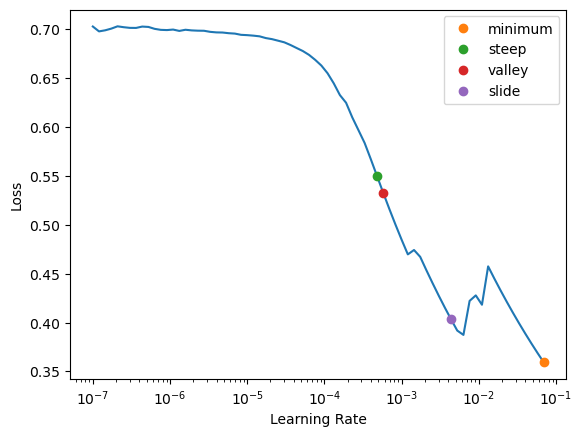

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136389,0.068904,0.984286,00:15
1,0.063152,0.070310,0.984286,00:16
2,0.077496,0.071316,0.984286,00:15


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07749594002962112
valid_loss 0.07131600379943848
accuracy_multi 0.9842856526374817


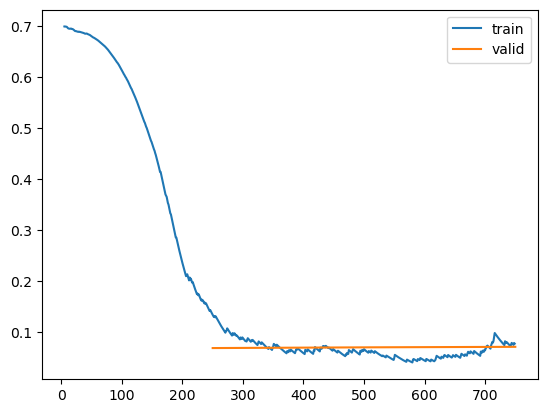

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["At two and a quarter hours this is a sometimes slow moving thoughtful film interrupted by vast sword battles. The battle between darkness and light is signified by the constant motif of the blazing sun and is superbly demonstrated by a three way fight between 'demons', bandits and soldiers in a forest during an eclipse.<br /><br />Be prepared: following a stunning sword fight under lightning filled skies the end of this picture will have you scratching your head in puzzlement.", "If you know the story of Grey Owl, you'll love the movie! Annie Galipeau is a great actress, and Pierce is better than never in Grey Owl. But in this movie there's no real scene of action. I think this movie should be nominated at the Oscars! Welll go see this movie, it's A CLASSIC!"], 'label': [1, 1], 'is_valid': [False, False]}

["At two and a quarter hours this is a sometimes slow moving thoughtful film interrupted by vast sword battles. The battle between dar

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-0f3d9c1e7b91aef4.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] To be honest i had heard this was pretty bad before i decided to watch it, but i'm never one to let others influence my viewings, in fact i'm more likely to watch something out of defiance!. Bullwhip had one thing going for me before the viewing anyway, the fact that Rhonda Fleming and those gorgeous eyes was in it had me interested right away. The picture isn't very good, and is in fact very morally dubious, all the characters are corrupt and shifty in one way shape or form, all motivated by greed or egocentric victories, this is all well and good if the surrounding film can do justice to a bunch of despicable people and create a taut climax shuddering picture. Sadly it doesn't, and as the finale fills your eyes with sugar you can't help shouting out that you have been cheated into watching a pretty bad film, nobody in the cast come out with any credit, with lead man Guy Madison painfully wooden in the extreme.<

tensor([0, 1, 0, 0])


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=1.2022644114040304e-06, steep=0.001737800776027143, valley=2.0892961401841603e-05, slide=0.0005754399462603033)

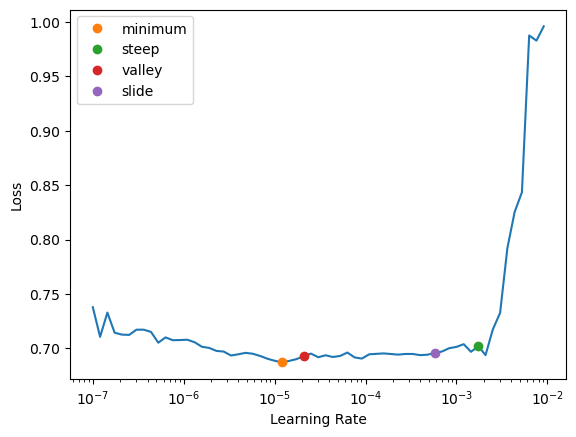

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.690122,0.637980,0.595000,00:22
1,0.183532,0.208569,0.880000,00:22
2,0.150718,0.218763,0.905000,00:22


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.15071766078472137
valid_loss 0.21876272559165955
accuracy 0.9049999713897705


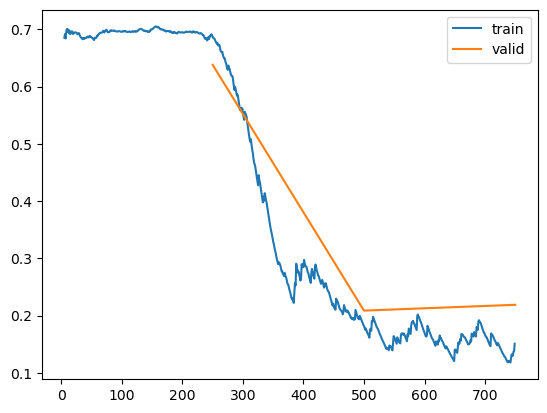

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['But you missed the 2nd order point as happens so often with reflexive/defensive type commenters: Even in a merely temporal sense (not to mention the supernatural effect which was an infinitely horrific offense) the violence against Jesus lowered the bar all around the people who witnessed it or even learned about it...they could go home and slap their wife and say.."well, this is nothing compared to the Nazarenian." \n\nJesus let a coarser and more grotesque example be set, lowering the bar for all.  He was complicit in it...He allowed it, even as a man. \n\nSo the "non violent" types ought to ask themselves a more demanding question, why?', "I wonder if you'd be quite so cavalier in excluding half the human race in Scriptural and liturgical language if your name were Donna or Danette or Denise?  Language matters."], 'toxicity': [0, 0], 'severe_toxicity': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_attack': [0

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
# proc_civil_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True, batch_size=4)
# proc_civil_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_civil_train_ds)
print(proc_civil_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})


##### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

# b

250 25
2

[CLS] Government contrived culture is not worth talking about.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.010000000149011612, steep=0.0004786300996784121, valley=0.0005754399462603033, slide=0.0063095735386013985)

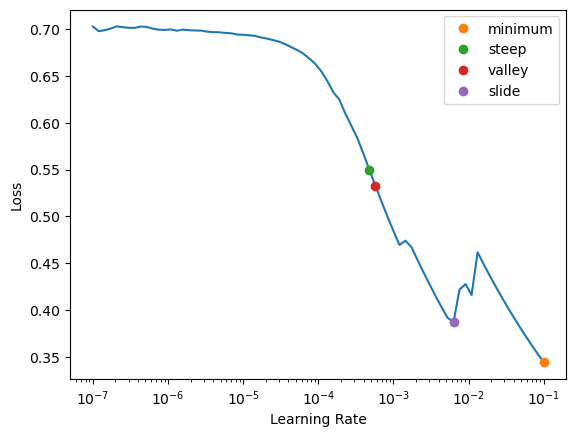

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136135,0.068907,0.984286,00:15
1,0.064932,0.070082,0.984286,00:14
2,0.076127,0.071195,0.984286,00:14


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07612712681293488
valid_loss 0.07119518518447876
accuracy_multi 0.9842856526374817


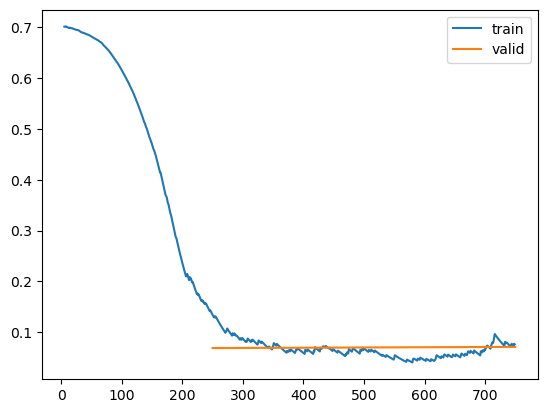

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API: Data

This section demonstrates how you can migrate from using PyTorch/Hugging Face to fast.ai `Datasets` and `DataLoaders` to recapture much of the fast.ai specific features unavailable when using basic PyTorch.

### `TextInput` -

In [ ]:
# |export
class TextInput(TensorBase):
    """The base represenation of your inputs; used by the various fastai `show` methods"""

    pass

A `TextInput` object is returned from the decodes method of `BatchDecodeTransform` as a means to customize `@typedispatch`ed functions like `DataLoaders.show_batch` and `Learner.show_results`. The value will the your "input_ids".

### `BatchDecodeTransform` -

In [ ]:
# |export
class BatchDecodeTransform(Transform):
    """A class used to cast your inputs as `input_return_type` for fastai `show` methods"""

    def __init__(
        self,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Any other keyword arguments
        **kwargs,
    ):
        store_attr()
        self.kwargs = kwargs

    def decodes(self, items: dict):
        """Returns the proper object and data for show related fastai methods"""
        return self.input_return_type(items["input_ids"])

        # inps = self.input_return_type(items[0]["input_ids"])
        # # inps = self.input_return_type(items[0][0])
        # if len(items) > 1:
        #     return inps, *items[1:]
        # else:
        #     labels = items[0].get("labels", [None] * items[0]["input_ids"])
        #     return inps, labels

As of fastai 2.1.5, before batch transforms no longer have a `decodes` method ... and so, I've introduced a standard batch transform here, `BatchDecodeTransform`, (one that occurs "after" the batch has been created) that will do the decoding for us.

### Utility classes and methods 

These methods are use internally for getting blurr transforms associated to your `DataLoaders`

In [ ]:
# |export
def get_blurr_tfm(
    # A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...)
    tfms_list: Pipeline,
    # The transform to find
    tfm_class: Transform = BatchDecodeTransform,
):
    """
    Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
    instance used in your Blurr DataBlock
    """
    return next(filter(lambda el: issubclass(type(el), tfm_class), tfms_list), None)

In [ ]:
nbdev.show_doc(get_blurr_tfm, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L272){target="_blank" style="float:right; font-size:smaller"}

### get_blurr_tfm

>      get_blurr_tfm (tfms_list:fastcore.transform.Pipeline,
>                     tfm_class:fastcore.transform.Transform=<class
>                     '__main__.BatchDecodeTransform'>)

Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
instance used in your Blurr DataBlock

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| tfms_list | Pipeline |  | A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...) |
| tfm_class | Transform | BatchDecodeTransform | The transform to find |

In [ ]:
# |export
def first_blurr_tfm(
    # Your fast.ai `DataLoaders
    dls: DataLoaders,
    # The Blurr transforms to look for in order
    tfms: list[Transform] = [BatchDecodeTransform],
):
    """
    This convenience method will find the first Blurr transform required for methods such as
    `show_batch` and `show_results`. The returned transform should have everything you need to properly
    decode and 'show' your Hugging Face inputs/targets
    """
    for tfm in tfms:
        found_tfm = get_blurr_tfm(dls.before_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

        found_tfm = get_blurr_tfm(dls.after_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

In [ ]:
nbdev.show_doc(first_blurr_tfm, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L285){target="_blank" style="float:right; font-size:smaller"}

### first_blurr_tfm

>      first_blurr_tfm (dls:fastai.data.core.DataLoaders,
>                       tfms:list[fastcore.transform.Transform]=[<class
>                       '__main__.BatchDecodeTransform'>])

This convenience method will find the first Blurr transform required for methods such as
`show_batch` and `show_results`. The returned transform should have everything you need to properly
decode and 'show' your Hugging Face inputs/targets

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dls | DataLoaders |  | Your fast.ai `DataLoaders |
| tfms | list[Transform] | [<class '__main__.BatchDecodeTransform'>] | The Blurr transforms to look for in order |

### `show_batch` -

In [ ]:
# |export
@typedispatch
def show_batch(
    # This typedispatched `show_batch` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # Your `DataLoaders`. This is required so as to get at the Hugging Face objects for
    # decoding them into something understandable
    dataloaders,
    # Your `show_batch` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_batch`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(dataloaders)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = dataloaders.n_inp

    n_samples = min(max_n, dataloaders.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        label = y[idx] if y is not None else None
        sample = samples[idx] if samples is not None else None

        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                if is_listy(item) and len(item) < 1:
                    trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)]
                else:
                    trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

### `TextDataLoader` -

In [ ]:
# |export
@delegates()
class TextDataLoader(TfmdDL):
    """
    A transformed `DataLoader` that works with Blurr.
    From the fastai docs: A `TfmDL` is described as "a DataLoader that creates Pipeline from a list of Transforms
    for the callbacks `after_item`, `before_batch` and `after_batch`. As a result, it can decode or show a processed batch.
    """

    def __init__(
        self,
        # A standard PyTorch Dataset
        dataset: torch.utils.data.dataset.Dataset | Datasets,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an  \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # An instance of `TextCollatorWithPadding` or equivalent (defaults to `BlurrBatchCreator`)
        text_collator: TextCollatorWithPadding = None,
        # The batch_tfm used to decode Blurr batches (defaults to `BatchDecodeTransform`)
        batch_decode_tfm: BatchDecodeTransform = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Keyword arguments to be applied to your `batch_decode_tfm`
        batch_decode_kwargs: dict = {},
        # Keyword arguments to be applied to `BlurrDataLoader`
        **kwargs,
    ):
        # define what happens when a batch is created (e.g., this is where collation happens)
        if "create_batch" in kwargs:
            kwargs.pop("create_batch")
        if not text_collator:
            text_collator = TextCollatorWithPadding(hf_tokenizer, hf_arch, hf_config, hf_model)

        # define the transform applied after the batch is created (used of show methods)
        if "after_batch" in kwargs:
            kwargs.pop("after_batch")
        if not batch_decode_tfm:
            batch_decode_tfm = BatchDecodeTransform(
                hf_tokenizer,
                hf_arch,
                hf_config,
                hf_model,
                input_return_type,
                **batch_decode_kwargs.copy(),
            )

        super().__init__(
            dataset=dataset,
            create_batch=text_collator,
            after_batch=batch_decode_tfm,
            **kwargs,
        )
        store_attr()

    def new(
        self,
        # A standard PyTorch and fastai dataset
        dataset: Union[torch.utils.data.dataset.Dataset, Datasets] = None,
        # The class you want to create an instance of (will be "self" if None)
        cls: type = None,
        #  Any additional keyword arguments you want to pass to the __init__ method of `cls`
        **kwargs,
    ):
        """
        We have to override the new method in order to add back the Hugging Face objects in this factory
        method (called for example in places like `show_results`). With the exception of the additions to the kwargs
        dictionary, the code below is pulled from the `DataLoaders.new` method as is.
        """
        # we need to add these arguments back in (these, after_batch, and create_batch will go in as kwargs)
        kwargs["hf_arch"] = self.hf_arch
        kwargs["hf_config"] = self.hf_config
        kwargs["hf_tokenizer"] = self.hf_tokenizer
        kwargs["hf_model"] = self.hf_model

        kwargs["text_collator"] = self.text_collator
        kwargs["batch_decode_tfm"] = self.batch_decode_tfm
        kwargs["batch_decode_kwargs"] = self.batch_decode_kwargs

        return super().new(dataset, cls, **kwargs)

### `sorted_dl_func` -

In [ ]:
# |export
def sorted_dl_func(
    example,
    # A Hugging Face tokenizer
    hf_tokenizer: PreTrainedTokenizerBase,
    # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
    # Set this to 'True' if your inputs are pre-tokenized (not numericalized)
    is_split_into_words: bool = False,
    # Any other keyword arguments you want to include during tokenization
    tok_kwargs: dict = {},
):
    """This method is used by the `SortedDL` to ensure your dataset is sorted *after* tokenization"""
    txt = None
    if isinstance(example[0], dict):
        if "input_ids" in example[0]:
            # if inputs are pretokenized
            return len(example[0]["input_ids"])
        else:
            txt = example[0]["text"]
    else:
        txt = example[0]

    return len(txt) if is_split_into_words else len(hf_tokenizer.tokenize(txt, **tok_kwargs))

In [ ]:
nbdev.show_doc(sorted_dl_func, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L446){target="_blank" style="float:right; font-size:smaller"}

### sorted_dl_func

>      sorted_dl_func (example, hf_tokenizer:transformers.tokenization_utils_bas
>                      e.PreTrainedTokenizerBase,
>                      is_split_into_words:bool=False, tok_kwargs:dict={})

This method is used by the `SortedDL` to ensure your dataset is sorted *after* tokenization

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| example |  |  |  |
| hf_tokenizer | PreTrainedTokenizerBase |  | A Hugging Face tokenizer |
| is_split_into_words | bool | False | The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \<br>Set this to 'True' if your inputs are pre-tokenized (not numericalized) |
| tok_kwargs | dict | {} | Any other keyword arguments you want to include during tokenization |

## Low-Level API: Training

In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        label = y[idx] if y is not None else None
        pred = outs[idx]
        sample = samples[idx] if samples is not None else None
        # add in the input text
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        # add in the targets
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                if is_listy(item) and len(item) < 1:
                    trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)]
                else:
                    trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        # add in the predictions
        for item in pred:
            if not torch.is_tensor(item):
                if is_listy(item) and len(item) < 1:
                    p = [trg_labels[idx] for idx, val in enumerate(item) if (val == 1)]
                else:
                    p = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                p = [trg_labels[idx] for idx, val in enumerate(item.numpy().tolist()) if (val == 1)] if (trg_labels) else item.numpy()
            else:
                p = trg_labels[item.item()] if (trg_labels) else item.item()

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

## Low-Level API: Examples

### Using fast.ai `Datasets` and `DataLoaders`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 1


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 50
2

[CLS] Lackawanna Blues is a touching story about Nanny, a woman who gives all of herself to help those in need. It's told from the viewpoint of a boy, taken in by Nanny when his own mother isn't quite up to the task.<br /><br />I have respect for this movie for three main reasons: 1) It is touching, but not sappy. It's told in a very real fashion, without a lot of the aggravating Hollywood storytelling baggage. And the ending is quite good (teary but not over-the-top).<br /><br />2) Although it's clearly an African-American film, being set in the post-segregation black community of Lackawanna, New York, it doesn't wear its ethnicity on its sleeve. The story stands on the strength of the characters and the dramas (and comedies) surrounding their lives. It's not preachy, it's simply good.<

tensor([1, 0, 0, 1], device='cuda:0')


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 2057)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 2057 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 2057 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.001737800776027143, valley=5.248074739938602e-05, slide=9.120108734350652e-05)

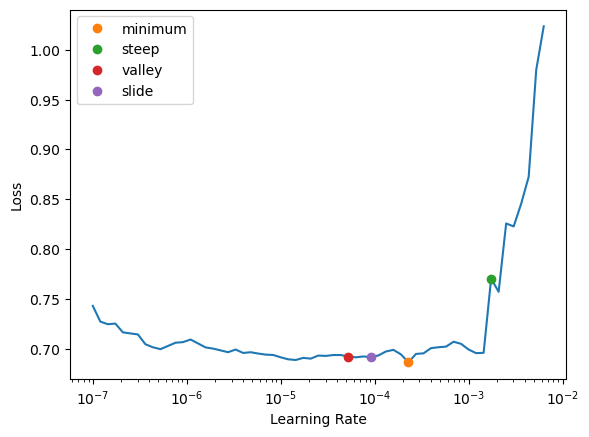

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.685003,0.605736,0.715000,00:21
1,0.208182,0.225672,0.900000,00:19
2,0.131485,0.210607,0.905000,00:20


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1314845234155655
valid_loss 0.21060672402381897
accuracy 0.9049999713897705


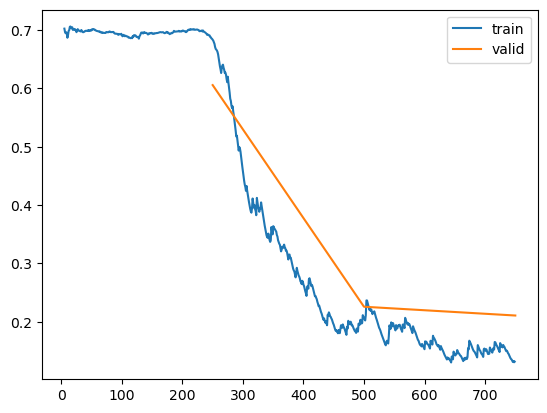

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
proc_civil_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_civil_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(civil_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): tensor([0, 0, 0, 0, 0, 0, 0])


##### Step 3: `DataLoaders`

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 50
2

[CLS] Even if Trump gets axed from office, Pence would no doubt do what Gerald Ford did and pardon Trump, his family and everyone else involved.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded while calling a Python object
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 276)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 276 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 276 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=0.04786301031708717, valley=9.120108734350652e-05, slide=0.0014454397605732083)

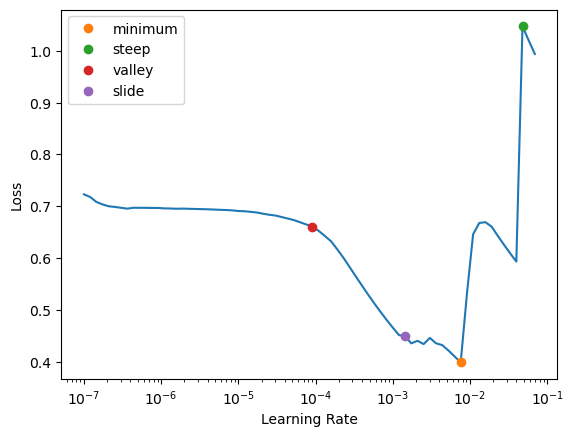

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.144614,0.074523,0.984286,00:21
1,0.065891,0.069993,0.984286,00:18
2,0.064943,0.071259,0.984286,00:18


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06494282931089401
valid_loss 0.07125858962535858
accuracy_multi 0.9842855930328369


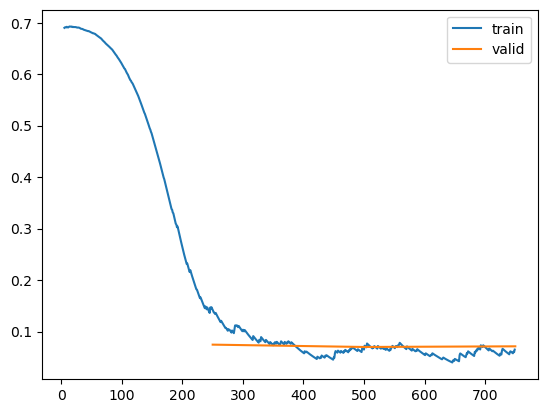

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with fastai Datasets/DataLoaders without transforms
# RecursionError: maximum recursion depth exceeded in __instancecheck__
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Using `BatchDecodeTransform` and `TextDataLoader`

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_imdb_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_imdb_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a363f2aa6fa0100c.arrow


##### Step 3: `DataLoaders`

In [ ]:
label_names = train_ds.features["label"].names
label_names

['neg', 'pos']

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] Lackawanna Blues is a touching story about Nanny, a woman who gives all of herself to help those in need. It's told from the viewpoint of a boy, taken in by Nanny when his own mother isn't quite up to the task.<br /><br />I have respect for this movie for three main reasons: 1) It is touching, but not sappy. It's told in a very real fashion, without a lot of the aggravating Hollywood storytelling baggage. And the ending is quite good (teary but not over-the-top).<br /><br />2) Although it's clearly an African-American film, being set in the post-segregation black community of Lackawanna, New York, it doesn't wear its ethnicity on its sleeve. The story stands on the strength of the characters and the dramas (and comedies) surrounding their lives. It's not preachy, it's simply good.<

tensor([1, 0, 0, 1, 0, 0, 0, 0])


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

,text,target
0,"St. Elmo's Fire has no bearing on life after university at all (for the majority of us common folk anyway). Why was this garbage even made? Who can really relate to this? Who lives like these characters? I truly feel sorry for the actors having to deal with such a terrible script. There are some talented young actors in this ""film"" that have done a good job elsewhere. It must have just been one whole joke to them on set.<br /><br />I actually found this ""film"" insulting to my intelligence. The only joy I got from this is hoping that Sir John Hughes had a good ol' laugh when he saw a screening of this the same year his masterpiece of The Breakfast Club was released.<br /><br />Don't make the same mistake I did of watching this because you enjoy 80's films. It really is that offensive to the",neg
1,"This is the only full length feature film about the world of bridge. I found the first 10 minutes a bit slow, but after that, the movie is absolutely perfect in describing professional bridge players and how they go about earning a living. <br /><br />Some of the scenes are very funny. I don't think that a non-bridge player would get the charm of this movie. <br /><br />Some of the dresses are really beautiful, pity the movie is in black and white - I can only imagine what they would look like in colour. The way the media are portrayed is absolutely hilarious. There is no way on earth bridge will ever be like that. <br /><br />Watch it as soon as you can, and tell your friends about it.",pos


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Lackawanna Blues is a touching story about Nanny, a woman who gives all of herself to help those in need. It's told from the viewpoint of a boy, taken in by Nanny when his own mother isn't quite up to the task.<br /><br />I have respect for this movi",pos
1,"This movie has to rank with ""Welcome to the Jungle"" and ""The Hitcher"" and ""Dream Catcher"" for sheer god-awfulness. You've got the most irritating heroine in gore history who spends most of her time sobbing and wailing and shrieking--all the time in t",neg


In [ ]:
# YES: Will work now that we're using fastai `TfmDL`s` and transforms
learn.summary()

BaseModelWrapper (Input shape: 4 x 309)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 309 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 309 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=2.7542287716642023e-05, steep=1.0964781722577754e-06, valley=9.120108734350652e-05, slide=0.0006918309954926372)

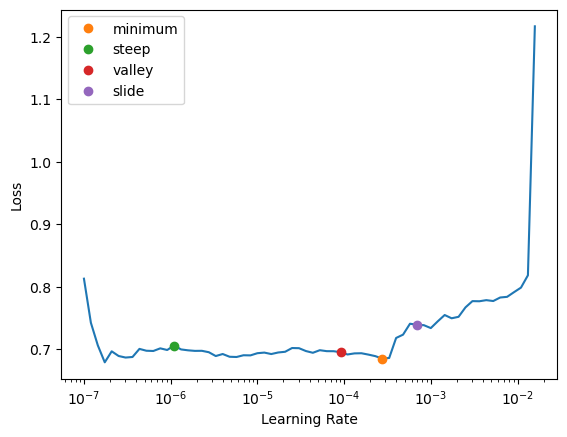

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.623537,0.406906,0.835000,00:23
1,0.218377,0.221203,0.890000,00:23
2,0.138875,0.225849,0.905000,00:23


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1388748735189438
valid_loss 0.22584888339042664
accuracy 0.9049999713897705


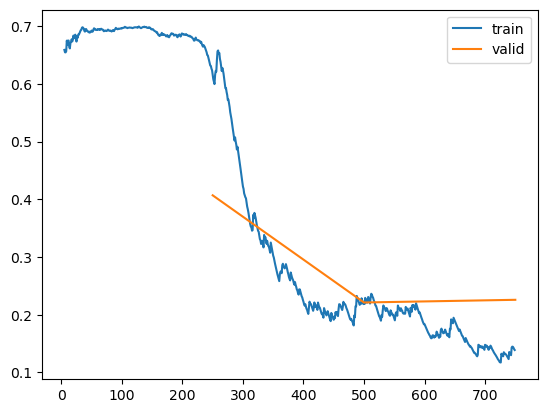

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Well, where to start? I stumbled across this one in 1993 and just hit ""record"" on the VCR out of habit, more than anything else. ""Citizen Kane"" it sure isn't...but if you've had a bad day and are in the mood for crashing out in front of something not too intellectually stimulating, then I tentatively suggest this might just be your ""thing"".<br /><br />We have the lot here - great title track, more stereotypes than you could shake a stick at, unconscious comedy, the bitchiest fight scene of all t",pos,pos
1,"I read a viciously hidden remarks on a previous comments stating that this film showed a bunch of gay guys romping around their gayness.<br /><br />This couldn't be more misleading. ""Eighteen"" is not a gay film. It has only three gay characters in it and one of them is the victim of prejudice of people like the one who wrote the comments, despite his confession of fairness.<br /><br />Pip's grandfather was not gay. The tender scene of the soldier and his sergeant is male bonding at the crucial m",pos,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])


# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_civil_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=proc_civil_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-fdebaaca7d664e4f.arrow


##### Step 3: `DataLoaders`

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": civil_labels},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] Even if Trump gets axed from office, Pence would no doubt do what Gerald Ford did and pardon Trump, his family and everyone else involved.[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
dls.show_batch(dataloaders=dls, max_n=8)

,text,target
0,"I know a number of people who voted for Trump mainly because they could not stand Clinton. They are not so happy with his performance so far but are still hopeful he can help ""fix"" america. We will see how long their hope will last. Now the hardcore Trump supporters are another matter, they will go over the cliff with him.",[]
1,"I'm not much of a rock fan, mostly country and gospel, but I do know country singer Johnny Cash was inducted into the Rock and Roll Hall of Fame in 1992 and he never had a single rock hit in his life, although a couple songs crossed over to 'pop', I don't think that would classify as rock and roll would it?",[]
2,"So, the Holy Spirit changes His mind?",[]
3,"According to some Jewish leaders, the most vocal proponent of anti-Semitism is Pope Francis. As they see it, every time he invokes the scribes and pharisees, Francis is slamming Judaism and the Jewish people. But ignore that. Always focus on Trump! rrrrrr!",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Even if Trump gets axed from office, Pence would no doubt do what Gerald Ford did and pardon Trump, his family and everyone else involved.",[]
1,"""authorities said civilian with a gun confronted the attacker and chased him away"" Everything changes with a muzzle aimed back at these murderers.",[]


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `learn.summary()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 89)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 89 x 768        
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 89 x 3072       
Linear                          

##### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=0.0003311311302240938, valley=0.00013182566908653826, slide=0.001737800776027143)

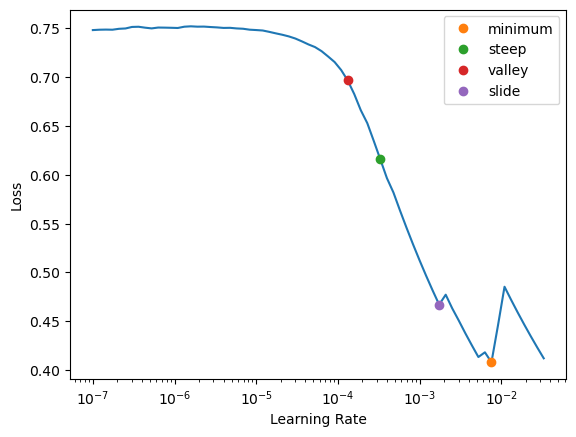

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.149026,0.070703,0.984286,00:17
1,0.054489,0.071083,0.984286,00:16
2,0.069823,0.069965,0.984286,00:17


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06982327997684479
valid_loss 0.06996502727270126
accuracy_multi 0.9842856526374817


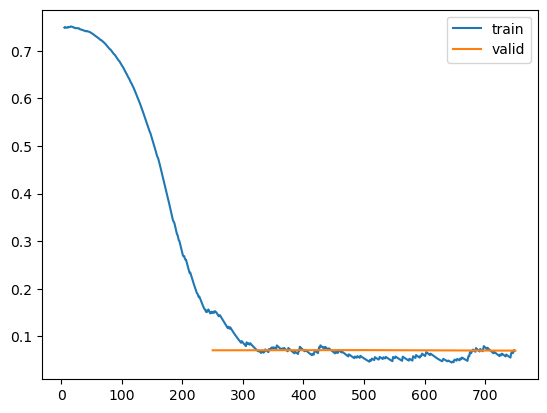

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Trump went to China with some corporate mob bosses who plan to announce new D E A L S with the Chinese. At the same time, a group of bipartisan Senators and Congressmen introduced legislation Wednesday that would subject Chinese investments to greater scrutiny through a significant expansion of the Committee on Foreign Investment in the United States, or CFIUS, a panel that reviews foreign mergers and acquisitions for potential threats to national security. Not only does the right hand of Trump'",[],[]
1,That is when the real wars will start...,[],[]


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API: Data

BLURR's mid-level API provides a way to build your `DataLoaders` using fast.ai's mid-level `DataBlock` API.  

BLURR supports three ways of doing this in the mid-level API: 

1. Using pre-tokenized data (the traditional approach)

2. batch-time tokenization (the default approach in previous versions of blurr)

2. item-time tokenization (e.g., to apply tokenization on individual items as they are pulled from their respective `Dataset`)

### `BatchTokenizeTransform` -

In [ ]:
# |export
class BatchTokenizeTransform(Transform):
    """
    Handles everything you need to assemble a mini-batch of inputs and targets, as well as
    decode the dictionary produced as a byproduct of the tokenization process in the `encodes` method.
    """

    def __init__(
        self,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # A Hugging Face model
        hf_model: PreTrainedModel,
        # To control whether the "labels" are included in your inputs. If they are, the loss will be calculated in \
        # the model's forward function and you can simply use `PreCalculatedLoss` as your `Learner`'s loss function to use it
        include_labels: bool = True,
        # The token ID that should be ignored when calculating the loss
        ignore_token_id: int = CrossEntropyLossFlat().ignore_index,
        # To control the length of the padding/truncation. It can be an integer or None, \
        # in which case it will default to the maximum length the model can accept. \
        # If the model has no specific maximum input length, truncation/padding to max_length is deactivated. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        max_length: int = None,
        # To control the `padding` applied to your `hf_tokenizer` during tokenization. \
        # If None, will default to 'False' or 'do_not_pad'. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        padding: bool | str = True,
        # To control `truncation` applied to your `hf_tokenizer` during tokenization. \
        # If None, will default to 'False' or 'do_not_truncate'. \
        # See [Everything you always wanted to know about padding and truncation](https://huggingface.co/transformers/preprocessing.html#everything-you-always-wanted-to-know-about-padding-and-truncation)
        truncation: bool | str = True,
        # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
        # Set this to 'True' if your inputs are pre-tokenized (not numericalized) \
        is_split_into_words: bool = False,
        # Any other keyword arguments you want included when using your `hf_tokenizer` to tokenize your inputs
        tok_kwargs: dict = {},
        # Keyword arguments to apply to `BatchTokenizeTransform`
        **kwargs,
    ):
        store_attr()
        self.kwargs = kwargs

    def encodes(self, samples, return_batch_encoding=False):
        """
        This method peforms on-the-fly, batch-time tokenization of your data. In other words, your raw inputs
        are tokenized as needed for each mini-batch of data rather than requiring pre-tokenization of your full
        dataset ahead of time.
        """
        samples = L(samples)

        # grab inputs
        is_dict = isinstance(samples[0][0], dict)
        test_inp = samples[0][0]["text"] if is_dict else samples[0][0]

        if is_listy(test_inp) and not self.is_split_into_words:
            if is_dict:
                inps = [(item["text"][0], item["text"][1]) for item in samples.itemgot(0).items]
            else:
                inps = list(zip(samples.itemgot(0, 0), samples.itemgot(0, 1)))
        else:
            inps = [item["text"] for item in samples.itemgot(0).items] if is_dict else samples.itemgot(0).items

        inputs = self.hf_tokenizer(
            inps,
            max_length=self.max_length,
            padding=self.padding,
            truncation=self.truncation,
            is_split_into_words=self.is_split_into_words,
            return_tensors="pt",
            **self.tok_kwargs,
        )

        d_keys = inputs.keys()

        # update the samples with tokenized inputs (e.g. input_ids, attention_mask, etc...), as well as extra information
        # if the inputs is a dictionary.
        # (< 2.0.0): updated_samples = [(*[{k: inputs[k][idx] for k in d_keys}], *sample[1:]) for idx, sample in enumerate(samples)]
        updated_samples = []
        for idx, sample in enumerate(samples):
            inps = {k: inputs[k][idx] for k in d_keys}
            if is_dict:
                inps = {
                    **inps,
                    **{k: v for k, v in sample[0].items() if k not in ["text"]},
                }

            trgs = sample[1:]
            if self.include_labels and len(trgs) > 0:
                inps["labels"] = trgs[0]

            updated_samples.append((*[inps], *trgs))

        if return_batch_encoding:
            return updated_samples, inputs

        return updated_samples

Inspired by this [article](https://docs.fast.ai/tutorial.transformers.html), `BatchTokenizeTransform` inputs can come in as raw **text**, **a list of words** (e.g., tasks like Named Entity Recognition (NER), where you want to predict the label of each token), or as a **dictionary** that includes extra information you want to use during post-processing.

**On-the-fly Batch-Time Tokenization**: 

Part of the inspiration for this derives from the mechanics of Hugging Face tokenizers, in particular it can return a collated mini-batch of data given a list of sequences. As such, the collating required for our inputs can be done during tokenization ***before*** our batch transforms run in a `before_batch_tfms` transform (where we get a list of examples)! This allows users of BLURR to have everything done dynamically at batch-time without prior preprocessing with at least four potential benefits:
1. Less code
2. Faster mini-batch creation
3. Less RAM utilization and time spent tokenizing beforehand (this really helps with very large datasets)
4. Flexibility

### `TextBlock` -

In [ ]:
# |export
class TextBlock(TransformBlock):
    """The core `TransformBlock` to prepare your inputs for training in Blurr with fastai's `DataBlock` API"""

    def __init__(
        self,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face tokenizer (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase = None,
        # A Hugging Face model (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # The "before_batch" transform you want to use if tokenizing your raw data on the fly (optional)
        tokenize_tfm: Transform = None,
        # The batch_tfm you want to decode your inputs into a type that can be used in the fastai show methods, \
        # (defaults to BatchDecodeTransform)
        batch_decode_tfm: BatchDecodeTransform = None,
        # To control whether the "labels" are included in your inputs. If they are, the loss will be calculated in \
        # the model's forward function and you can simply use `PreCalculatedLoss` as your `Learner`'s loss function to use it
        include_labels: bool = True,
        # The `is_split_into_words` argument applied to your `hf_tokenizer` during tokenization. \
        # Set this to `True` if your inputs are pre-tokenized (not numericalized)
        is_split_into_words: bool = False,
        # The return type your decoded inputs should be cast too (used by methods such as `show_batch`)
        input_return_type: type = TextInput,
        # The type of `DataLoader` you want created (defaults to `SortedDL`)
        dl_type: DataLoader = None,
        # Any keyword arguments you want applied to your `batch_decode_tfm` (will be set as a fastai `batch_tfms`)
        batch_decode_kwargs: dict = {},
        # Any keyword arguments you want your Hugging Face tokenizer to use during tokenization
        tok_kwargs: dict = {},
        # Any keyword arguments you want to have applied with generating text
        text_gen_kwargs: dict = {},
        # Any keyword arguments you want applied to `TextBlock`
        **kwargs,
    ):
        if (not all([hf_arch, hf_config, hf_tokenizer, hf_model])) and tokenize_tfm is None:
            raise ValueError("You must supply an hf_arch, hf_config, hf_tokenizer, hf_model -or- a tokenize_tfm")

        # if we are using a transform to tokenize our inputs, grab the HF objects from it
        if tokenize_tfm is not None:
            hf_arch = getattr(tokenize_tfm, "hf_arch", hf_arch)
            hf_config = getattr(tokenize_tfm, "hf_config", hf_config)
            hf_tokenizer = getattr(tokenize_tfm, "hf_tokenizer", hf_tokenizer)
            hf_model = getattr(tokenize_tfm, "hf_model", hf_model)
            is_split_into_words = getattr(tokenize_tfm, "is_split_into_words", is_split_into_words)
            include_labels = getattr(tokenize_tfm, "include_labels", include_labels)

        # configure our batch decode transform (used by show_batch/results methods)
        if batch_decode_tfm is None:
            batch_decode_tfm = BatchDecodeTransform(
                hf_arch=hf_arch,
                hf_config=hf_config,
                hf_tokenizer=hf_tokenizer,
                hf_model=hf_model,
                input_return_type=input_return_type,
                **batch_decode_kwargs.copy(),
            )

        # default to SortedDL using our custom sort function if no `dl_type` is specified
        if dl_type is None:
            dl_sort_func = partial(
                sorted_dl_func, hf_tokenizer=hf_tokenizer, is_split_into_words=is_split_into_words, tok_kwargs=tok_kwargs.copy()
            )
            dl_type = partial(SortedDL, sort_func=dl_sort_func)

        # build our custom `TransformBlock`
        data_collator = TextCollatorWithPadding(hf_tokenizer)
        dl_kwargs = {"create_batch": data_collator} if tokenize_tfm is None else {"before_batch": tokenize_tfm}
        return super().__init__(dl_type=dl_type, dls_kwargs=dl_kwargs, batch_tfms=batch_decode_tfm)

## Mid-Level API: Examples

### Pretokenized

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(labels)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)

# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(
    hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, batch_decode_kwargs={"labels": label_names}
)

blocks = (txt_block, CategoryBlock)
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the HF dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a363f2aa6fa0100c.arrow


In [ ]:
dls = dblock.dataloaders(proc_imdb_ds, bs=4)

In [ ]:
b = dls.one_batch()
len(b), len(b[0]["input_ids"]), b[0]["input_ids"].shape, len(b[1])

(2, 4, torch.Size([4, 2057]), 4)

In [ ]:
b[0]

{'input_ids': tensor([[    1,   879,   286,  ...,  1215,   260,     2],
         [    1,  1304, 11445,  ...,     0,     0,     0],
         [    1,   643, 49964,  ...,     0,     0,     0],
         [    1,   273,  3535,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': tensor([0, 1, 0, 0], device='cuda:0')}

Let's take a look at the actual types represented by our batch

In [ ]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorCategory]}

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Some have praised -Atlantis:-The Lost Empire- as a Disney adventure for adults. I don't think so--at least not for thinking adults.<br /><br />This script suggests a beginning as a live-action movie, that struck someone as the type of crap you cannot sell to adults anymore. The ""crack staff"" of many older adventure movies has been done well before, (think The Dirty Dozen) but -Atlantis- represents one of the worse films in that motif. The characters are weak. Even the background that each member",neg
1,"Many neglect that this isn't just a classic due to the fact that it's the first 3D game, or even the first shoot-'em-up. It's also one of the first stealth games, one of the only(and definitely the first) truly claustrophobic games, and just a pretty well-rounded gaming experience in general. With graphics that are terribly dated today, the game thrusts you into the role of B.J.(don't even *think* I'm going to attempt spelling his last name!), an American P.O.W. caught in an underground bunker.",pos


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Lackawanna Blues is a touching story about Nanny, a woman who gives all of herself to help those in need. It's told from the viewpoint of a boy, taken in by Nanny when his own mother isn't quite up to the task.<br /><br />I have respect for this movi",pos
1,"This movie has to rank with ""Welcome to the Jungle"" and ""The Hitcher"" and ""Dream Catcher"" for sheer god-awfulness. You've got the most irritating heroine in gore history who spends most of her time sobbing and wailing and shrieking--all the time in t",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 2057)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 2057 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 2057 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=6.309573450380412e-08, steep=1.5848931980144698e-06, valley=6.30957365501672e-05, slide=0.0004786300996784121)

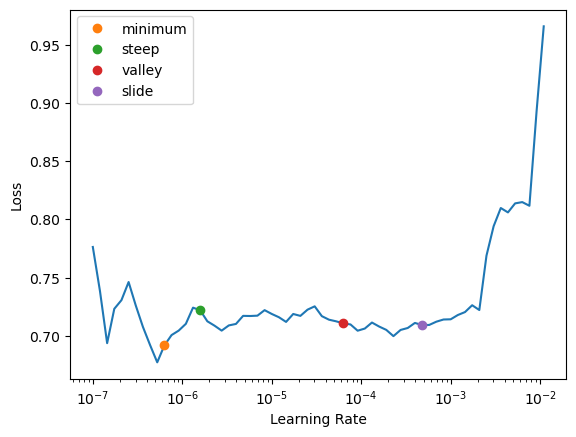

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.689965,0.656623,0.660000,00:20
1,0.249683,0.232531,0.895000,00:20
2,0.149595,0.228623,0.905000,00:20


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1495947390794754
valid_loss 0.22862271964550018
accuracy 0.9049999713897705


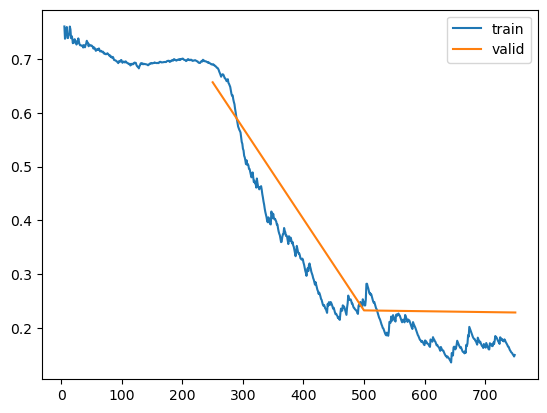

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Lackawanna Blues is a touching story about Nanny, a woman who gives all of herself to help those in need. It's told from the viewpoint of a boy, taken in by Nanny when his own mother isn't quite up to the task.<br /><br />I have respect for this movie for three main reasons: 1) It is touching, but not sappy. It's told in a very real fashion, without a lot of the aggravating Hollywood storytelling baggage. And the ending is quite good (teary but not over-the-top).<br /><br />2) Although it's clea",pos,pos
1,"Having not read the book, I was more open to the fresh interpretation that each director gives to their medium (which is film, not ""to the letter"" reproductions of literature)on this particular film. I was happy that the holocaust that occurred in Russia (and it's neighboring countries) finally received some attention. The Nazis were particularly cruel to Russians and Russian Jews. If you read the histories and see the monuments built in Smolensk and nearby regions you will understand this movie",pos,pos


In [ ]:
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)

# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(
    hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, batch_decode_kwargs={"labels": label_names}
)

blocks = (txt_block, MultiCategoryBlock(encoded=True, vocab=civil_labels))
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_labels], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-fdebaaca7d664e4f.arrow


In [ ]:
dls = dblock.dataloaders(proc_civil_ds, bs=4)

In [ ]:
b = dls.one_batch()
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([4, 276]), torch.Size([4, 7]))

In [ ]:
b[0]

{'input_ids': tensor([[   1, 2115,  464,  ...,  302,  323,    2],
         [   1,  944,  262,  ...,    0,    0,    0],
         [   1,  273,  284,  ...,    0,    0,    0],
         [   1,  463,  270,  ...,    0,    0,    0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': tensor([[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}

Let's take a look at the actual types represented by our batch

In [ ]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorMultiCategory]}

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Where did you get those bizarre figures? First, are you talking about television or websites? Thatcher's original claim was that ""G&M ranks 3,000+ in global web site traffic and RT is 350"" - ""website traffic"", not viewers. He was hilariously wrong, as my link proved. Either way, your figures are wildly off. CNN has 2M viewers weekly? Fox has 3.5M viewers weekly? Here's the hard numbers: ""Daytime viewership was also dominated by Fox as it pulled in 2.09 million. CNN’s programming reeled in 1.04 m",[]
1,"Where are your new ideas? You know, ones that aren't proven failed Republican ideas, like ""trickle down theory"" which they're still touting and tort reform? All tort reform did - yes, it's already been done, genius - is make it harder for the little guy to get just compensation when a doctor screwed up and cut off the wrong leg. The argument then was that passing tort reform would lower insurance premiums. It was obviously a lie then and it's a lie now. Same with trickle down theory. Doesn't wor",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Even if Trump gets axed from office, Pence would no doubt do what Gerald Ford did and pardon Trump, his family and everyone else involved.",[]
1,"""authorities said civilian with a gun confronted the attacker and chased him away"" Everything changes with a muzzle aimed back at these murderers.",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 276)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 276 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 276 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0006309573538601399, steep=0.009120108559727669, valley=0.00013182566908653826, slide=0.001737800776027143)

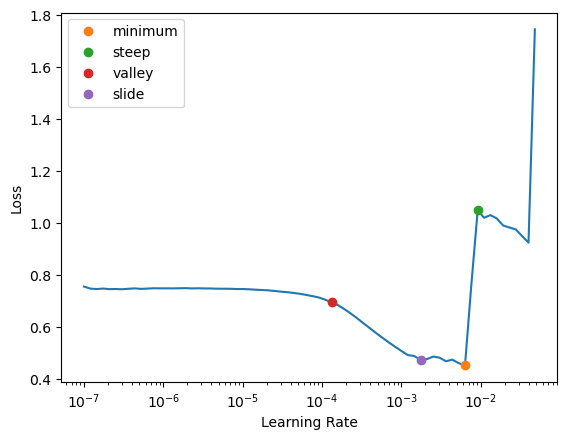

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.149926,0.070827,0.984286,00:17
1,0.065566,0.069780,0.984286,00:17
2,0.064429,0.069387,0.984286,00:18


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06442932039499283
valid_loss 0.0693865492939949
accuracy_multi 0.9842855930328369


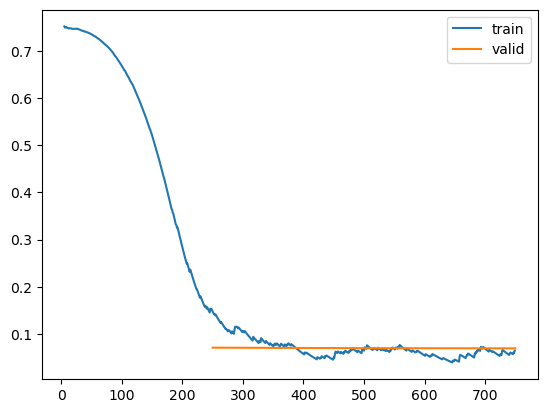

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Even if Trump gets axed from office, Pence would no doubt do what Gerald Ford did and pardon Trump, his family and everyone else involved.",[],[]
1,"That's right. That's why Canadian born in those ridings should either run for office as an independent by getting signatures as per instructions www.elections.ca, or support pro-Canadian MPs independent or otherwise. Replacing our dysfunctional MPs is what needs to be done.",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Batch-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(label_names)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (
    TextBlock(tokenize_tfm=tokenize_tfm, batch_decode_kwargs={"labels": label_names}),
    CategoryBlock,
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
b = dls.one_batch()
len(b), len(b[0]["input_ids"]), b[0]["input_ids"].shape, len(b[1])

(2, 4, torch.Size([4, 2057]), 4)

In [ ]:
b[0]

{'input_ids': tensor([[    1,   879,   286,  ...,  1215,   260,     2],
         [    1,  1304, 11445,  ...,     0,     0,     0],
         [    1,   273,  1367,  ...,     0,     0,     0],
         [    1,   643, 49964,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': TensorCategory([0, 1, 0, 0], device='cuda:0')}

Let's take a look at the actual types represented by our batch

In [ ]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorCategory]}

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Some have praised -Atlantis:-The Lost Empire- as a Disney adventure for adults. I don't think so--at least not for thinking adults.<br /><br />This script suggests a beginning as a live-action movie, that struck someone as the type of crap you cannot sell to adults anymore. The ""crack staff"" of many older adventure movies has been done well before, (think The Dirty Dozen) but -Atlantis- represents one of the worse films in that motif. The characters are weak. Even the background that each member",neg
1,"I absolutely despise this movie. No wonder Jose Larraz ""disowned"" it at one point and refuses to discuss it. I admire Larraz's work, especially his more obscure slasher/sex maniac thrillers like SAVAGE LUST or SCREAM AND DIE. His work has a kind of inescapable artiness about it that he can't seem to switch off, owing in part to his secondary career as a painter & cartoonist. It's too bad he never made a Western, his vision would have been perfect.<br /><br />BLACK CANDLES is easily his most noto",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"The commercials for RAT RACE made it look too juvenile for me to enjoy, but since my boyfriend adores this movie (and the soundtrack), I finally relented and watched it with him tonight. I make him watch David Lynch films and all sorts of obscure ind",neg
1,"The topic of religion in Buñuel films is a point that one, as an eater of films, as an eater of art or as a person need to analyze hardly. One can see to a satirical Buñuel in ""La Voie Lactée"", ""Un Chien Andalou"" or in ""L'Age d'Or"". Is very hard and",pos


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 2057)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 2057 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 2057 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.001737800776027143, valley=5.248074739938602e-05, slide=0.0010000000474974513)

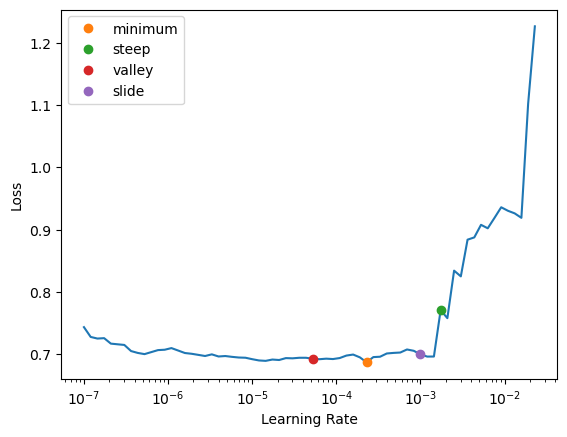

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.668820,0.548672,0.785000,00:22
1,0.235911,0.201118,0.885000,00:29
2,0.128753,0.203451,0.910000,00:20


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.1287529468536377
valid_loss 0.20345087349414825
accuracy 0.9100000262260437


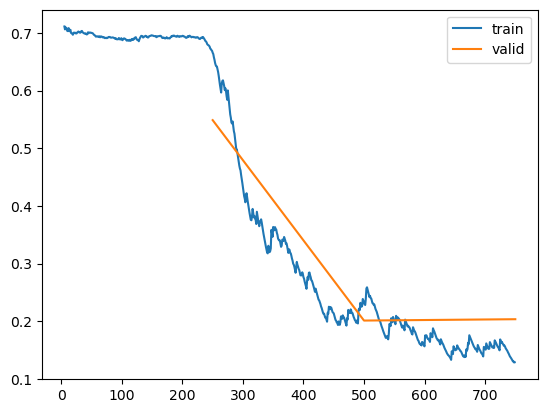

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"The commercials for RAT RACE made it look too juvenile for me to enjoy, but since my boyfriend adores this movie (and the soundtrack), I finally relented and watched it with him tonight. I make him watch David Lynch films and all sorts of obscure indie stuff (I recently forced URBANIA on him), so I felt I owed him an innocuous Hollywood product.<br /><br />I didn't want to hurt his feelings, so I saved my bitching for y'alls. Yeah, RAT RACE has its moments, but a great deal of it irritated me. L",neg,neg
1,"The topic of religion in Buñuel films is a point that one, as an eater of films, as an eater of art or as a person need to analyze hardly. One can see to a satirical Buñuel in ""La Voie Lactée"", ""Un Chien Andalou"" or in ""L'Age d'Or"". Is very hard and effective in its critic, but when you have seen this and then you see a movie like ""Nazarin"", after you see this work you begin to be questioned about its author. And much have questioned about what seems to be a contradiction for Buñuel thinks, but",pos,pos


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_new_hf_objects(civil_labels)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm), MultiCategoryBlock(encoded=True, vocab=civil_labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader(civil_labels), splitter=ColSplitter())

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
b = dls.one_batch()
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([4, 276]), torch.Size([4, 7]))

In [ ]:
b[0]

{'input_ids': tensor([[   1, 2115,  464,  ...,  302,  323,    2],
         [   1,  944,  262,  ...,    0,    0,    0],
         [   1,  273,  284,  ...,    0,    0,    0],
         [   1,  463,  270,  ...,    0,    0,    0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': TensorMultiCategory([[0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')}

Let's take a look at the actual types represented by our batch

In [ ]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorMultiCategory]}

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"Where did you get those bizarre figures? First, are you talking about television or websites? Thatcher's original claim was that ""G&M ranks 3,000+ in global web site traffic and RT is 350"" - ""website traffic"", not viewers. He was hilariously wrong, as my link proved. Either way, your figures are wildly off. CNN has 2M viewers weekly? Fox has 3.5M viewers weekly? Here's the hard numbers: ""Daytime viewership was also dominated by Fox as it pulled in 2.09 million. CNN’s programming reeled in 1.04 m",[]
1,"Where are your new ideas? You know, ones that aren't proven failed Republican ideas, like ""trickle down theory"" which they're still touting and tort reform? All tort reform did - yes, it's already been done, genius - is make it harder for the little guy to get just compensation when a doctor screwed up and cut off the wrong leg. The argument then was that passing tort reform would lower insurance premiums. It was obviously a lie then and it's a lie now. Same with trickle down theory. Doesn't wor",[]


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"If a company poisons water, air, or land, and someone's child dies causal to the exposure, and many people and professionals stated it might, or would probably happen, but the Corporation and corrupt politicians gamed the system to allow the activity",[]
1,I shouldn't be surprised but am at the lack of common sense and plethora of conspiracy theories that abound. A lot of you just like to bitch and complain without offering solutions. For decades now we've been collecting PFD's for nothing (other than,[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 276)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 276 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 276 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.0006309573538601399, steep=0.009120108559727669, valley=0.00013182566908653826, slide=0.001737800776027143)

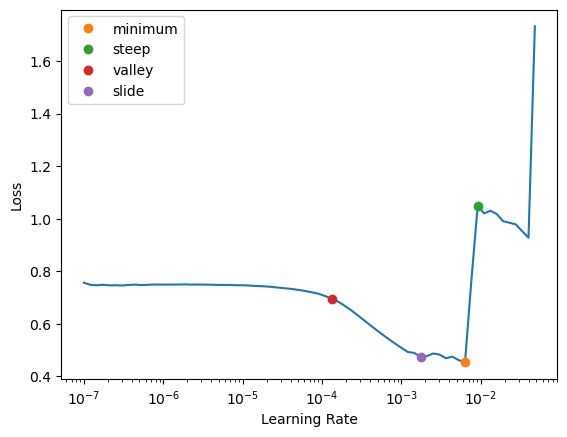

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.149924,0.070821,0.984286,00:18
1,0.065569,0.069780,0.984286,00:18
2,0.064429,0.069392,0.984286,00:18


In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06442918628454208
valid_loss 0.06939195841550827
accuracy_multi 0.9842856526374817


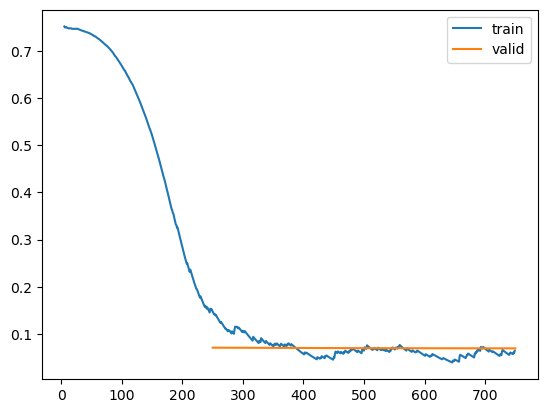

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"If a company poisons water, air, or land, and someone's child dies causal to the exposure, and many people and professionals stated it might, or would probably happen, but the Corporation and corrupt politicians gamed the system to allow the activity/poisoning, what rights does the poisoned person or their family have? If government is easily corrupted to allow blatant Corporate negligence, then must citizens decide whether or not they have a personal right to implement exacting and personal jus",[],[]
1,"I shouldn't be surprised but am at the lack of common sense and plethora of conspiracy theories that abound. A lot of you just like to bitch and complain without offering solutions. For decades now we've been collecting PFD's for nothing (other than putting up with some cold weather and ostensibly giving up ""our oil"" that's pumped from the ground). NO OTHER STATE DOES THIS. Say what you like about PFD raids but you've gotten virtually a free ride until now. For better or for worse, we live in a",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Inference

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
# |export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None, tok_is_split_into_words=False):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    batch_tok_tfm = get_blurr_tfm(self.dls.before_batch, tfm_class=BatchTokenizeTransform)

    hf_tokenizer = tfm.hf_tokenizer
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    is_split_into_words = getattr(tfm, "is_split_into_words", tok_is_split_into_words)
    is_split_str = is_split_into_words == True and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    # we need to tokenize our items *if* we are not using the mid-level API batch-time tokenization
    if batch_tok_tfm is None:
        inputs_d = dict(
            hf_tokenizer(
                items, is_split_into_words=is_split_into_words, padding=True, max_length=True, truncation=True, return_tensors="pt"
            )
        )
        items = [{k: inputs_d[k][idx] for k in inputs_d.keys()} for idx in range(len(inputs_d["input_ids"]))]

    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]

        if trg_labels:
            # handle multiclass output
            if isinstance(item_dec_labels, str) or isinstance(item_dec_labels, int):
                item_dec_labels = [trg_labels[int(item_dec_labels)]]
            elif len(item_dec_labels.size()) == 0:
                item_dec_labels = [item_dec_labels.item()]
            # handle multilabel output
            else:
                item_dec_labels = [trg_labels[lbl_idx] for lbl_idx, lbl in enumerate(item_dec_labels) if lbl == True]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        if trg_labels is not None or hasattr(self.dls, "vocab"):
            res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        else:
            res["class_labels"] = None

        res["probs"] = item_probs[0].tolist()

        outs.append(res)
    return outs

In [ ]:
nbdev.show_doc(Learner.blurr_predict)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L717){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_predict

>      Learner.blurr_predict (items, rm_type_tfms=None,
>                             tok_is_split_into_words=False)

### Multiclass

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level.pkl")

In [ ]:
inf_learn.blurr_predict("This is perhaps the best movie I have ever seen!!!")

[{'label': 1,
  'score': 0.6755658388137817,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.3244341015815735, 0.6755658388137817]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 1,
  'score': 0.7420452833175659,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.2579547166824341, 0.7420452833175659]},
 {'label': 0,
  'score': 0.6385290622711182,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.6385290622711182, 0.3614709675312042]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level.pkl")

In [ ]:
inf_learn.blurr_predict("Acting was so bad it was almost funny.")

[{'label': 'neg',
  'score': 0.8036355972290039,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.8036355972290039, 0.1963643729686737]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 'pos',
  'score': 0.8608312606811523,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.13916876912117004, 0.8608312606811523]},
 {'label': 'neg',
  'score': 0.6867742538452148,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.6867742538452148, 0.31322580575942993]}]

### Multilabel

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
inf_learn.blurr_predict("I will tell everyone what you did if you tell you jerk!")

[{'labels': [],
  'scores': [],
  'class_indices': [0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['toxicity',
   'severe_toxicity',
   'obscene',
   'threat',
   'insult',
   'identity_attack',
   'sexual_explicit'],
  'probs': [0.03846954181790352,
   0.0008827652782201767,
   0.0015107328072190285,
   0.0021009522024542093,
   0.030016424134373665,
   0.002168499631807208,
   0.0006967081571929157]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
inf_learn.loss_func.thresh = 0.02


comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes.
No enchiladas for them!
"""
inf_learn.blurr_predict(comment)

[{'labels': ['toxicity', 'insult'],
  'scores': [0.04469436779618263, 0.03286498412489891],
  'class_indices': [1, 0, 0, 0, 1, 0, 0],
  'class_labels': ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
  'probs': [0.04469436779618263,
   0.0008904251735657454,
   0.0014745199587196112,
   0.002223622752353549,
   0.03286498412489891,
   0.002023482695221901,
   0.0006377939134836197]}]

In [ ]:
# |echo:false
try:
    del inf_learn
except:
    pass
finally:
    clean_memory()

## Text Generation

With regards to **text generation**, though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# |export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results

In [ ]:
nbdev.show_doc(Learner.blurr_generate)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L789){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_generate

>      Learner.blurr_generate (items, key='generated_texts', **kwargs)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()